# Barotropic to baroclinic conversion
Following Nycander (2005) and Zilberman et al. (2009)

TODO, compare:
 - topo from LUCKY (750m)
 - topo from SRTM30_PLUS (30'')
 - topo from TPXO8
 
Details:
- tidal current are expressed in the grid of the topo (rotated)
- Convention, angles positive cc-wise: 
 -- for grid angle from xi to E ; 
 -- for INC from E to semi-major axis

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.usetex'] = False
import scipy.interpolate as interp
import scipy.signal as signal
import scipy.stats as stats
from netCDF4 import Dataset
import time
from datetime import datetime

from SW_Density import SW_Density as rhop # temporary
#from comp_rho import rhop
#from distance_sphere_matproof import dist_sphere_matproof
from convert_TPXO_to_ellipses import get_tpxo7_on_grid, get_tpxo8_on_grid
from pad_coords import pad_coords   # for padding fields outside of domain
from detrend_2d import detrend_2d

doverb = True


In [2]:
# --- data location ---
path_data = 'prov/' #'/data0/project/vortex/lahaye/Tide_Conv/input_data/' #'./input_data/' #
#path_data = '/net/krypton'+path_data     # if not on LOPS hub

# --- climato ---
clim = "lucky"
if clim == "lucky":
    cname = path_data+"lucky_ts_meanSODA_winter.nc"

# --- topography dataset --- 
topo = "lucky" # "tpxo" # "srtm"
if topo == 'lucky':
    file_topo = path_data+"lucky_corgrd.nc"
    varx, vary = 'lon_rho', 'lat_rho'
    varh = 'h'
elif topo == 'srtm':
    file_topo = TODO
    varx, vary = TODO
    varh = TODO
elif topo == 'tpxo8':
    file_topo = TODO
    varx, vary = TODO
    varh = TODO

# --- tide dataset --- 
tide = 'tpxo7' #'lucky' #

if tide == 'lucky':
    uname = path_data+'luckym2_frc.nc' 
elif tide == "tpxo7":
    uname = path_data+"u_tpxo7.2.nc"
    gname = path_data+"grid_tpxo7.2.nc"
elif tide == 'tpxo8':
    uname = "/net/ruchba/local/tmp/2/lahaye/TPXO8/uv.m2_tpxo8_atlas_30c_v1.nc"
    gname = uname.replace("uv.m2","grid")
    
zmin       = -100              # min depth to compute Ef [m], below contin. shelf roughly
g          = 9.81              # gravity [m s-2]
M2         = 2*np.pi/12.42          # M2 tide frequency [rad/hour] 
Erad = 6371e3                  # Earth radius [m]

In [3]:
# ------ get mean topo on the grid, will be used to get N2b --------
# load the entire grid (regional modelling purpose)
nc   = Dataset(file_topo,'r') # etopo2 and srtm30 files have the same structure
if topo == 'lucky':
    lon_h = nc.variables[varx][:].T
    lat_h = nc.variables[vary][:].T
    nlon_h, nlat_h = lon_h.shape
    h_t = -nc.variables[varh][:].T
    h_t[h_t>=-2.5] = 0     # land points   # "raw" topo (for FFT)
    h_ma = np.ma.masked_where(h_t==0,-h_t) # masked topo
    dx_h = 1/nc.variables['pm'][:].T
    dy_h = 1/nc.variables['pn'][:].T
    gang = nc.variables['angle'][:].T # grid angle (rad., between xi (origin) and E, pos. cc-wise)
nc.close()

#dhdx = np.diff(h_t,axis=0)/0.5/(dx_h[1:,:]+dx_h[:-1,:])
#dhdx = np.r_[dhdx[:1,:]/2.,(dhdx[1:,:]+dhdx[:-1,:])/2,dhdx[-1:,:]/2.]
#dhdy = np.diff(h_t,axis=1)/0.5/(dy_h[:,1:]+dy_h[:,:-1])
#dhdy = np.c_[dhdy[:,:1]/2.,(dhdy[:,1:]+dhdy[:,:-1])/2,dhdy[:,-1:]/2.]
dhdx, dhdy = np.gradient(h_t,dx_h.mean(),dy_h.mean())

fcor = 2.*(2*np.pi/24.)*np.sin(lat_h*np.pi/180.) # coriolis, rad/hour

In [26]:
# ------ extract Tides ------------------------------

if tide == 'lucky':
    nc = Dataset(uname,'r')
    # angle between major axis and east [rad] (beware sign)
    phi = nc.variables['tide_Cangle'][0,...].T*np.pi/180.
    # tide phase ()
    pha = nc.variables['tide_Cphase'][0,...].T*np.pi/180.
    # tidal current amplitude (major, minor axes)
    ue = nc.variables['tide_Cmax'][0,...].T
    ve = nc.variables['tide_Cmin'][0,...].T
    nc.close()
elif tide == 'tpxo7':
    ubt, uphi, vbt, vphi = get_tpxo7_on_grid([uname,gname],lon_h,lat_h,grang=gang) 
    pha = np.deg2rad(vphi-uphi)
elif tide == 'tpxo8':
    ubt, uphi, vbt, vphi = get_tpxo8_on_grid([uname,gname],lon_h,lat_h,grang=gang) 
    pha = np.deg2rad(vphi-uphi)

# conversion to grid coordinates
if tide == 'lucky':
    ubt = ue*np.cos(phi-gang)*np.cos(pha) - ve*np.sin(phi-gang)*np.sin(pha)
    vbt = ue*np.sin(phi-gang)*np.cos(pha) + ve*np.cos(phi-gang)*np.sin(pha)
    

/Users/noney/tmp/Int_Tide_Conv/convert_TPXO_to_ellipses.py:121: RuntimeWarning: divide by zero encountered in true_divide
  ure = nc.variables['URe'][itide,indxu,indyu]/hu    # cm²/s to m/s
/Users/noney/tmp/Int_Tide_Conv/convert_TPXO_to_ellipses.py:121: RuntimeWarning: invalid value encountered in true_divide
  ure = nc.variables['URe'][itide,indxu,indyu]/hu    # cm²/s to m/s
/Users/noney/tmp/Int_Tide_Conv/convert_TPXO_to_ellipses.py:122: RuntimeWarning: divide by zero encountered in true_divide
  vre = nc.variables['VRe'][itide,indxv,indyv]/hv
/Users/noney/tmp/Int_Tide_Conv/convert_TPXO_to_ellipses.py:123: RuntimeWarning: divide by zero encountered in true_divide
  uim = nc.variables['UIm'][itide,indxu,indyu]/hu
/Users/noney/tmp/Int_Tide_Conv/convert_TPXO_to_ellipses.py:123: RuntimeWarning: invalid value encountered in true_divide
  uim = nc.variables['UIm'][itide,indxu,indyu]/hu
/Users/noney/tmp/Int_Tide_Conv/convert_TPXO_to_ellipses.py:124: RuntimeWarning: divide by zero encountered

In [27]:
# ------ extract density profile, compute N2 ------------------
if clim == "lucky":
    nc = Dataset(cname,'r')
    T = nc.variables['temp_roms_avg'][:]
    S = nc.variables['salt_roms_avg'][:]
    zz = nc.variables['depth'][:]
    nz = zz.size
    
rho = np.sort(rhop(T,S)) #SW_Density(T,S) # sorting is cheating here
rho0 = rho.mean()
frho = interp.pchip(zz[::-1],rho[::-1],extrapolate=True)
N2_tmp = -(g/rho0)*frho.derivative()(zz)    # take routine
# temporary fixing:
if N2_tmp[-1]==0: N2_tmp[-1] = 1e-8
indneg, = np.where(N2_tmp<=0.)
for ii in indneg:
    N2_tmp[ii] = (N2_tmp[ii-1] + N2_tmp[ii+1])/2
fN2 = interp.pchip(zz[::-1],N2_tmp,extrapolate=True)    


# fit exponential profile
slope,intercept,r_val,p_val,std_err = stats.linregress(zz,np.log(N2_tmp**0.5))
N0  = np.exp(intercept)
b   = 1./slope
N2b = np.sqrt(fN2(h_t))

if doverb:
    if indneg.size>0:
        print('had to resort stratif for {} values'.format(indneg.size))
    print('exponential interpolation for stratification: N0={0}, b={1}'.format(N0,b))
    
coef = rho0*N2b/2*np.sqrt(1-fcor**2/M2**2)

def kn_expN(n,h,omega=M2/3600,f=fcor/3600,b=b,N0=N0):
    """ 
    approximate for modal horizontal wavenumber given exponential fit for the stratification 
    of the form N=N0.exp(z/b) with z algebraic depth
    h is bottom depth (absolute value) 
    omega, f: tidal and Coriolis frequencies (rad/s)
    following StLaurent & Garrett 2002"""
    return n*np.pi*np.sqrt((omega**2-f**2)/(b**2*N0**2*(1-np.exp(-h/b))**2-(h*omega)**2))

kone = np.nanmean(kn_expN(1,h_ma))
print('1st mode mean hor. wavelength: {} km'.format(2*np.pi/kone/1e3))

exponential interpolation for stratification: N0=0.002967003410995782, b=1472.7289614711035
1st mode mean hor. wavelength: 60.47855215597036 km


In [28]:
# define spectral filter (finite depth effects)
def spe_filt(kk,kone=1.,fmod='heavy'):
    if fmod == 'heavy':
        return (kk>kone).astype(float)
    elif fmod is None:
        return np.ones(kk.shape)

In [29]:
### go for it -- this version valid for LUCKY topo
dowin = False
npad = 500

if doverb:
    tmes, tmeb = time.clock(), time.time()
    
h = detrend_2d(h_t) # apply bilinear detrend
if npad > 0:
    h = np.pad(h,npad,'edge')
else:
    h = h.copy()
nx, ny = h.shape
dxi, dyi = dx_h.mean(), dy_h.mean()
kx = np.fft.fftfreq(nx,dxi)*2*np.pi    # wavenumbers in x-direction = major axis
ky = np.fft.fftfreq(ny,dyi)*2*np.pi    # wavenumbers in x-direction = major axis
dkx, dky = kx[1]-kx[0], ky[1]-ky[0]
modk = np.sqrt(kx[:,None]**2 + ky[None,:]**2)
if dowin:
    win_x = np.hanning(nx)[None,:]  # window before filtering 
    win_y = np.hanning(ny)[:,None]
else:
    win_x = np.ones((1,nx))
    win_y = np.ones((ny,1))
win = np.dot(win_y,win_x)
int_rec = nx*ny             # integral of a squared rectangular window (as if no windowing) 
int_win = np.nansum(win**2) # integral of the squared window 
norm    = (int_rec/int_win)*1/(nx*ny*dkx*dky) # [1/(rad m-1)^2] normalization constant 
if doverb:
    print('ready for FFT',time.clock()-tmes,time.time()-tmeb)
    tmes, tmeb = time.clock(), time.time()
tfh = np.fft.fft2(h*win)
if doverb:
    print('FFT done',time.clock()-tmes,time.time()-tmeb)
    tmes, tmeb = time.clock(), time.time()

# TODO add spectral filter and compute modified ifft2
modl = 1./modk
modl[modk==0.] = 0.
#sdxh = np.fft.ifft2(1j*kx[:,None]*modl*tfh).real
#sdyh = np.fft.ifft2(1j*ky[None,:]*modl*tfh).real
sdxh = np.fft.ifft2(1j*kx[:,None]*spe_filt(modk,kone)*modl*tfh).real
sdyh = np.fft.ifft2(1j*ky[None,:]*spe_filt(modk,kone)*modl*tfh).real
#sdxh = np.fft.ifft2(1j*kx[:,None]*spe_filt(modk,kone)*tfh).real
#sdyh = np.fft.ifft2(1j*ky[None,:]*spe_filt(modk,kone)*tfh).real
if npad > 0:
    sdxh = sdxh[npad:-npad,npad:-npad]
    sdyh = sdyh[npad:-npad,npad:-npad]
if doverb:
    print('inv. FFTs done',time.clock()-tmes,time.time()-tmeb)

P_pos = coef*dhdx*(ubt**2*sdxh + ubt*vbt*np.cos(pha)*sdyh)
P_neg = coef*dhdy*(vbt**2*sdyh + ubt*vbt*np.cos(pha)*sdxh)
C_t = P_pos + P_neg

ready for FFT 0.5512059999999934 0.531501054763794
FFT done 1.9858289999999954 1.9849789142608643


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


inv. FFTs done 5.073235999999994 5.073231935501099


0.15531970526975522

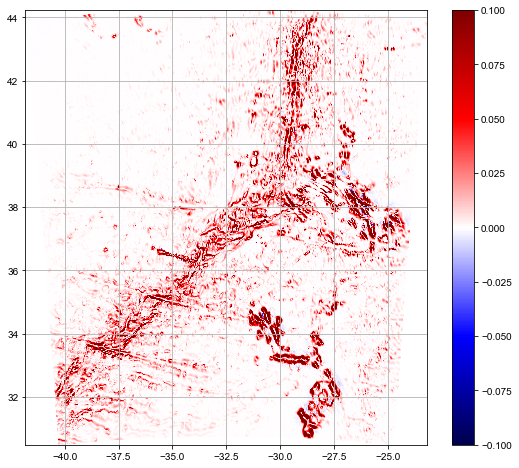

In [39]:
mini, maxi = np.array([-1,1])*.1
#mini, maxi = np.array([-1,1])*2.5e3
toplot = C_t

fig = plt.figure(figsize=(9,8))
#plt.pcolormesh(lon_h.T,lat_h.T,toplot.T,cmap='seismic')
plt.pcolormesh(lon_h.T,lat_h.T,toplot.T,cmap='seismic',vmin=mini,vmax=maxi)
plt.colorbar()
plt.grid(True)

C_t.max(), C_t.min(), np.nansum(C_t*dxi*dyi)
(C_t<0).sum()/C_t.size

In [37]:
C_t.shape, C_t.size

((2002, 2002), 4008004)

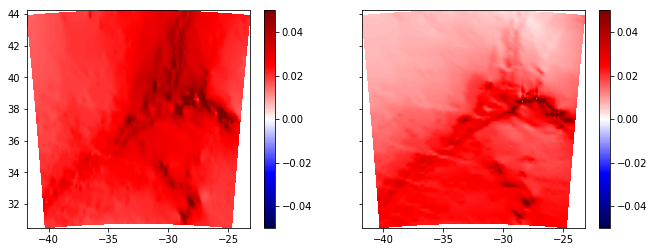

In [28]:
#plt.pcolormesh(h*win)
mini, maxi = np.array([-1,1])*.05

fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(11,4))
hpm = ax1.pcolormesh(lon_h.T,lat_h.T,ubt.T,cmap='seismic',vmin=mini,vmax=maxi)
plt.colorbar(hpm,ax=ax1)
hpm = ax2.pcolormesh(lon_h.T,lat_h.T,vbt.T,cmap='seismic',vmin=mini,vmax=maxi)
plt.colorbar(hpm,ax=ax2)

In [31]:
gang.min(), gang.max()

(-0.0012512334192851941, 0.0012512334192851941)

(-8.1916083470114223e-05, 0.020760202753804542)

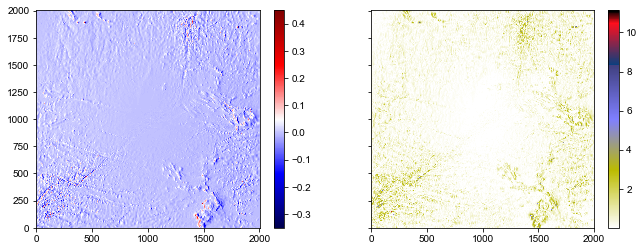

In [137]:
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(11,4))
hpm = ax1.pcolormesh((dhdx-sdxh).T,cmap='seismic')
plt.colorbar(hpm,ax=ax1)
hpm = ax2.pcolormesh(np.abs(dhdx-sdxh).T/dhdx.std(),cmap='gist_stern_r')
plt.colorbar(hpm,ax=ax2)

(dhdx-sdxh).mean(), (dhdx-sdxh).std()

(0.997766381623-0.000687148128711j)


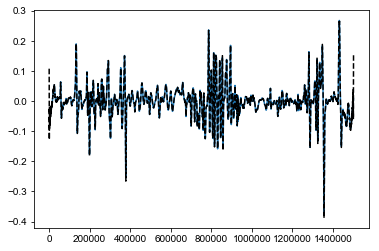

In [60]:
## OK for 1D differentiation, although I'm not sure how to normalize the results

ind = 1001

yy = h[:,ind]
xx = np.cumsum(dx_h[:,ind])
xdif = 0.5*(xx[1:] + xx[:-1])

Nx = len(xx)
dx = xx[1] - xx[0]

kx = np.fft.fftfreq(Nx,dx)*2*np.pi
tfh = np.fft.fft(yy)
sdh = np.fft.ifft(1j*kx*tfh)
dy = np.diff(yy)/dx

print(dy.max()/sdh.max())

plt.plot(xdif,dy,xx,sdh,'--k')